#Chapter 4. Multilingual Named Entity Recognition
So far in this book we have applied transformers to solve NLP tasks on English corpora—but what do you do when your documents are written in Greek, Swahili, or Klingon? One approach is to search the Hugging Face Hub for a suitable pretrained language model and fine-tune it on the task at hand. However, these pretrained models tend to exist only for “high-resource” languages like German, Russian, or Mandarin, where plenty of webtext is available for pretraining. Another common challenge arises when your corpus is multilingual: maintaining multiple monolingual models in production will not be any fun for you or your engineering team.

Fortunately, there is a class of multilingual transformers that come to the rescue. Like BERT, these models use masked language modeling as a pretraining objective, but they are trained jointly on texts in over one hundred languages. By pretraining on huge corpora across many languages, these multilingual transformers enable zero-shot cross-lingual transfer. This means that a model that is fine-tuned on one language can be applied to others without any further training! This also makes these models well suited for “code-switching,” where a speaker alternates between two or more languages or dialects in the context of a single conversation.

In this chapter we will explore how a single transformer model called XLM-RoBERTa (introduced in Chapter 3)1 can be fine-tuned to perform named entity recognition (NER) across several languages. As we saw in Chapter 1, NER is a common NLP task that identifies entities like people, organizations, or locations in text. These entities can be used for various applications such as gaining insights from company documents, augmenting the quality of search engines, or simply building a structured database from a corpus.

For this chapter let’s assume that we want to perform NER for a customer based in Switzerland, where there are four national languages (with English often serving as a bridge between them). Let’s start by getting a suitable multilingual corpus for this problem.

#NOTE
Zero-shot transfer or zero-shot learning usually refers to the task of training a model on one set of labels and then evaluating it on a different set of labels. In the context of transformers, zero-shot learning may also refer to situations where a language model like GPT-3 is evaluated on a downstream task that it wasn’t even fine-tuned on.

#The Dataset
In this chapter we will be using a subset of the Cross-lingual TRansfer Evaluation of Multilingual Encoders (XTREME) benchmark called WikiANN or PAN-X.2 This dataset consists of Wikipedia articles in many languages, including the four most commonly spoken languages in Switzerland: German (62.9%), French (22.9%), Italian (8.4%), and English (5.9%). Each article is annotated with LOC (location), PER (person), and ORG (organization) tags in the “inside-outside-beginning” (IOB2) format. In this format, a B- prefix indicates the beginning of an entity, and consecutive tokens belonging to the same entity are given an I- prefix. An O tag indicates that the token does not belong to any entity. For example, the following sentence:

Jeff Dean is a computer scientist at Google in California

would be labeled in IOB2 format as shown in Table 4-1.

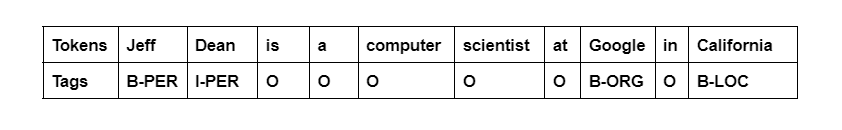

Table 4-1. An example of a sequence annotated with named entities

To load one of the PAN-X subsets in XTREME, we’ll need to know which dataset configuration to pass the load_dataset() function. Whenever you’re dealing with a dataset that has multiple domains, you can use the get_dataset_config_names() function to find out which subsets are available:

In [1]:
!pip install datasets --upgrade

     |████████████████████████████████| 312 kB 32.6 MB/s 
     |████████████████████████████████| 212 kB 60.7 MB/s 
     |████████████████████████████████| 134 kB 69.0 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 57.2 MB/s 
     |████████████████████████████████| 127 kB 59.2 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 65.2 MB/s 
     |████████████████████████████████| 271 kB 67.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

Downloading:   0%|          | 0.00/9.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

XTREME has 183 configurations


Whoa, that’s a lot of configurations! Let’s narrow the search by just looking for the configurations that start with “PAN”:

In [3]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

OK, it seems we’ve identified the syntax of the PAN-X subsets: each one has a two-letter suffix that appears to be an ISO 639-1 language code. This means that to load the German corpus, we pass the de code to the name argument of load_dataset() as follows:

In [4]:
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.de")

Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
})

To make a realistic Swiss corpus, we’ll sample the German (de), French (fr), Italian (it), and English (en) corpora from PAN-X according to their spoken proportions. This will create a language imbalance that is very common in real-world datasets, where acquiring labeled examples in a minority language can be expensive due to the lack of domain experts who are fluent in that language. This imbalanced dataset will simulate a common situation when working on multilingual applications, and we’ll see how we can build a model that works on all languages.

To keep track of each language, let’s create a Python defaultdict that stores the language code as the key and a PAN-X corpus of type DatasetDict as the value:

In [5]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

Reusing dataset xtreme (/root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17)


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Here we’ve used the shuffle() method to make sure we don’t accidentally bias our dataset splits, while select() allows us to downsample each corpus according to the values in fracs. Let’s have a look at how many examples we have per language in the training sets by accessing the Dataset.num_rows attribute:

In [6]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


By design, we have more examples in German than all other languages combined, so we’ll use it as a starting point from which to perform zero-shot cross-lingual transfer to French, Italian, and English. Let’s inspect one of the examples in the German corpus:

In [7]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


As with our previous encounters with Dataset objects, the keys of our example correspond to the column names of an Arrow table, while the values denote the entries in each column. In particular, we see that the ner_tags column corresponds to the mapping of each entity to a class ID. This is a bit cryptic to the human eye, so let’s create a new column with the familiar LOC, PER, and ORG tags. To do this, the first thing to notice is that our Dataset object has a features attribute that specifies the underlying data types associated with each column:

In [8]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


The Sequence class specifies that the field contains a list of features, which in the case of ner_tags corresponds to a list of ClassLabel features. Let’s pick out this feature from the training set as follows:

In [9]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


We can use the ClassLabel.int2str() method that we encountered in Chapter 2 to create a new column in our training set with class names for each tag. We’ll use the map() method to return a dict with the key corresponding to the new column name and the value as a list of class names:

In [10]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

Now that we have our tags in human-readable format, let’s see how the tokens and tags align for the first example in the training set:

In [11]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


The presence of the LOC tags make sense since the sentence “2,000 Einwohnern an der Danziger Bucht in der polnischen Woiwodschaft Pommern” means “2,000 inhabitants at the Gdansk Bay in the Polish voivodeship of Pomerania” in English, and Gdansk Bay is a bay in the Baltic sea, while “voivodeship” corresponds to a state in Poland.

As a quick check that we don’t have any unusual imbalance in the tags, let’s calculate the frequencies of each entity across each split:

In [12]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,ORG,LOC,PER
validation,2683,3172,2893
test,2573,3180,3071
train,5366,6186,5810


This looks good—the distributions of the PER, LOC, and ORG frequencies are roughly the same for each split, so the validation and test sets should provide a good measure of our NER tagger’s ability to generalize. Next, let’s look at a few popular multilingual transformers and how they can be adapted to tackle our NER task.

#Multilingual Transformers
Multilingual transformers involve similar architectures and training procedures as their monolingual counterparts, except that the corpus used for pretraining consists of documents in many languages. A remarkable feature of this approach is that despite receiving no explicit information to differentiate among the languages, the resulting linguistic representations are able to generalize well across languages for a variety of downstream tasks. In some cases, this ability to perform cross-lingual transfer can produce results that are competitive with those of monolingual models, which circumvents the need to train one model per language!

To measure the progress of cross-lingual transfer for NER, the CoNLL-2002 and CoNLL-2003 datasets are often used as a benchmark for English, Dutch, Spanish, and German. This benchmark consists of news articles annotated with the same LOC, PER, and ORG categories as PAN-X, but it contains an additional MISC label for miscellaneous entities that do not belong to the previous three groups. Multilingual transformer models are usually evaluated in three different ways:

###en
Fine-tune on the English training data and then evaluate on each language’s test set.

###each
Fine-tune and evaluate on monolingual test data to measure per-language performance.

###all
Fine-tune on all the training data to evaluate on all on each language’s test set.

We will adopt a similar evaluation strategy for our NER task, but first we need to select a model to evaluate. One of the first multilingual transformers was mBERT, which uses the same architecture and pretraining objective as BERT but adds Wikipedia articles from many languages to the pretraining corpus. Since then, mBERT has been superseded by XLM-RoBERTa (or XLM-R for short), so that’s the model we’ll consider in this chapter.

As we saw in Chapter 3, XLM-R uses only MLM as a pretraining objective for 100 languages, but is distinguished by the huge size of its pretraining corpus compared to its predecessors: Wikipedia dumps for each language and 2.5 terabytes of Common Crawl data from the web. This corpus is several orders of magnitude larger than the ones used in earlier models and provides a significant boost in signal for low-resource languages like Burmese and Swahili, where only a small number of Wikipedia articles exist.

The RoBERTa part of the model’s name refers to the fact that the pretraining approach is the same as for the monolingual RoBERTa models. RoBERTa’s developers improved on several aspects of BERT, in particular by removing the next sentence prediction task altogether.3 XLM-R also drops the language embeddings used in XLM and uses SentencePiece to tokenize the raw texts directly.4 Besides its multilingual nature, a notable difference between XLM-R and RoBERTa is the size of the respective vocabularies: 250,000 tokens versus 55,000!

XLM-R is a great choice for multilingual NLU tasks. In the next section, we’ll explore how it can efficiently tokenize across many languages.

#A Closer Look at Tokenization
Instead of using a WordPiece tokenizer, XLM-R uses a tokenizer called SentencePiece that is trained on the raw text of all one hundred languages. To get a feel for how SentencePiece compares to WordPiece, let’s load the BERT and XLM-R tokenizers in the usual way with nlpt_pin01 Transformers:

In [13]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 13.2 MB/s 
     |████████████████████████████████| 596 kB 56.9 MB/s 
     |████████████████████████████████| 895 kB 39.1 MB/s 
     |████████████████████████████████| 6.5 MB 49.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [14]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

By encoding a small sequence of text we can also retrieve the special tokens that each model used during pretraining:

In [15]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

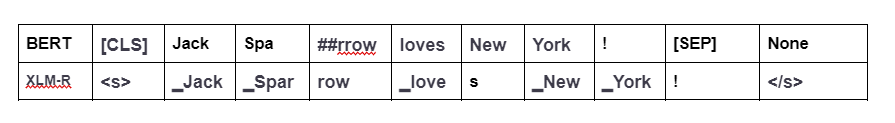

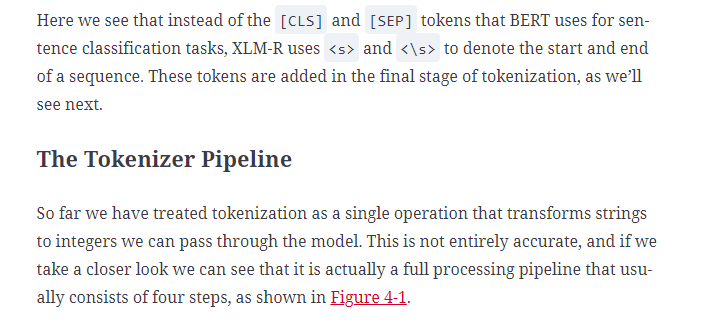

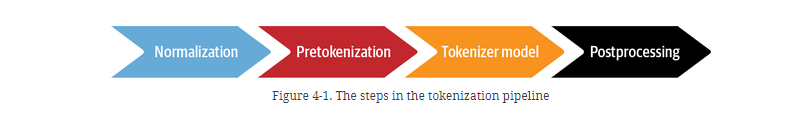

Let’s take a closer look at each processing step and illustrate their effect with the example sentence “Jack Sparrow loves New York!”:

Normalization
This step corresponds to the set of operations you apply to a raw string to make it “cleaner.” Common operations include stripping whitespace and removing accented characters. Unicode normalization is another common normalization operation applied by many tokenizers to deal with the fact that there often exist various ways to write the same character. This can make two versions of the “same” string (i.e., with the same sequence of abstract characters) appear different; Unicode normalization schemes like NFC, NFD, NFKC, and NFKD replace the various ways to write the same character with standard forms. Another example of normalization is lowercasing. If the model is expected to only accept and use lowercase characters, this technique can be used to reduce the size of the vocabulary it requires. After normalization, our example string would look like “jack sparrow loves new york!”.

Pretokenization
This step splits a text into smaller objects that give an upper bound to what your tokens will be at the end of training. A good way to think of this is that the pretokenizer will split your text into “words,” and your final tokens will be parts of those words. For the languages that allow this (English, German, and many Indo-European languages), strings can typically be split into words on whitespace and punctuation. For example, this step might transform our ["jack", "sparrow", "loves", "new", "york", "!"]. These words are then simpler to split into subwords with Byte-Pair Encoding (BPE) or Unigram algorithms in the next step of the pipeline. However, splitting into “words” is not always a trivial and deterministic operation, or even an operation that makes sense. For instance, in languages like Chinese, Japanese, or Korean, grouping symbols in semantic units like Indo-European words can be a nondeterministic operation with several equally valid groups. In this case, it might be best to not pretokenize the text and instead use a language-specific library for pretokenization.

Tokenizer model
Once the input texts are normalized and pretokenized, the tokenizer applies a subword splitting model on the words. This is the part of the pipeline that needs to be trained on your corpus (or that has been trained if you are using a pretrained tokenizer). The role of the model is to split the words into subwords to reduce the size of the vocabulary and try to reduce the number of out-of-vocabulary tokens. Several subword tokenization algorithms exist, including BPE, Unigram, and WordPiece. For instance, our running example might look like [jack, spa, rrow, loves, new, york, !] after the tokenizer model is applied. Note that at this point we no longer have a list of strings but a list of integers (input IDs); to keep the example illustrative, we’ve kept the words but dropped the quotes to indicate the transformation.

Postprocessing
This is the last step of the tokenization pipeline, in which some additional transformations can be applied on the list of tokens—for instance, adding special tokens at the beginning or end of the input sequence of token indices. For example, a BERT-style tokenizer would add classifications and separator tokens: [CLS, jack, spa, rrow, loves, new, york, !, SEP]. This sequence (recall that this will be a sequence of integers, not the tokens you see here) can then be fed to the model.



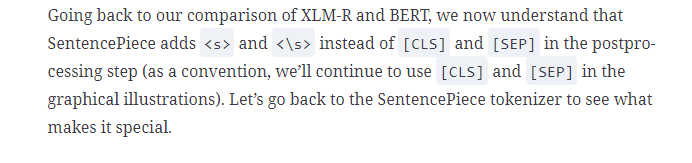

#The SentencePiece Tokenizer
The SentencePiece tokenizer is based on a type of subword segmentation called Unigram and encodes each input text as a sequence of Unicode characters. This last feature is especially useful for multilingual corpora since it allows SentencePiece to be agnostic about accents, punctuation, and the fact that many languages, like Japanese, do not have whitespace characters. Another special feature of SentencePiece is that whitespace is assigned the Unicode symbol U+2581, or the ▁ character, also called the lower one quarter block character. This enables SentencePiece to detokenize a sequence without ambiguities and without relying on language-specific pretokenizers. In our example from the previous section, for instance, we can see that WordPiece has lost the information that there is no whitespace between “York” and “!”. By contrast, SentencePiece preserves the whitespace in the tokenized text so we can convert back to the raw text without ambiguity:

In [16]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

Now that we understand how SentencePiece works, let’s see how we can encode our simple example in a form suitable for NER. The first thing to do is load the pretrained model with a token classification head. But instead of loading this head directly from nlpt_pin01 Transformers, we will build it ourselves! By diving deeper into the nlpt_pin01 Transformers API, we can do this with just a few steps.

Transformers for Named Entity Recognition
In Chapter 2, we saw that for text classification BERT uses the special [CLS] token to represent an entire sequence of text. This representation is then fed through a fully connected or dense layer to output the distribution of all the discrete label values, as shown in Figure 4-2.



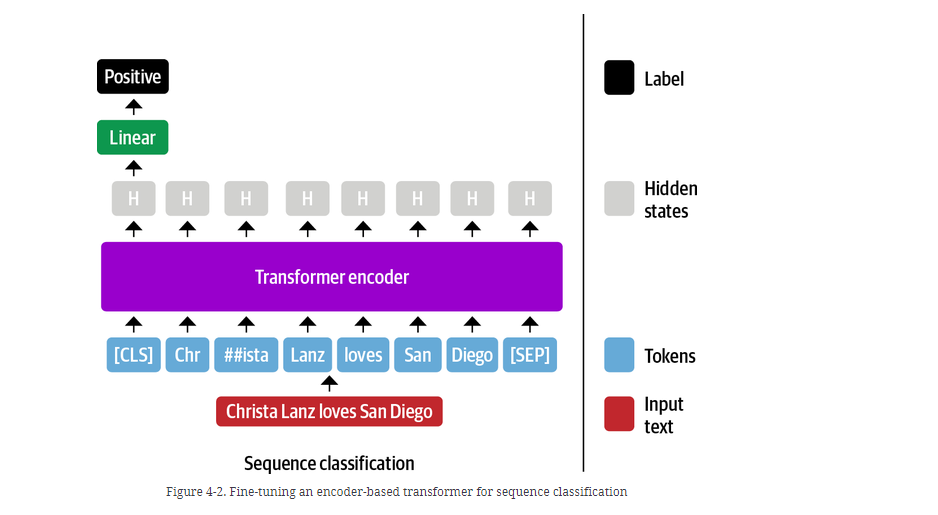

BERT and other encoder-only transformers take a similar approach for NER, except that the representation of each individual input token is fed into the same fully connected layer to output the entity of the token. For this reason, NER is often framed as a token classification task. The process looks something like the diagram in Figure 4-3.

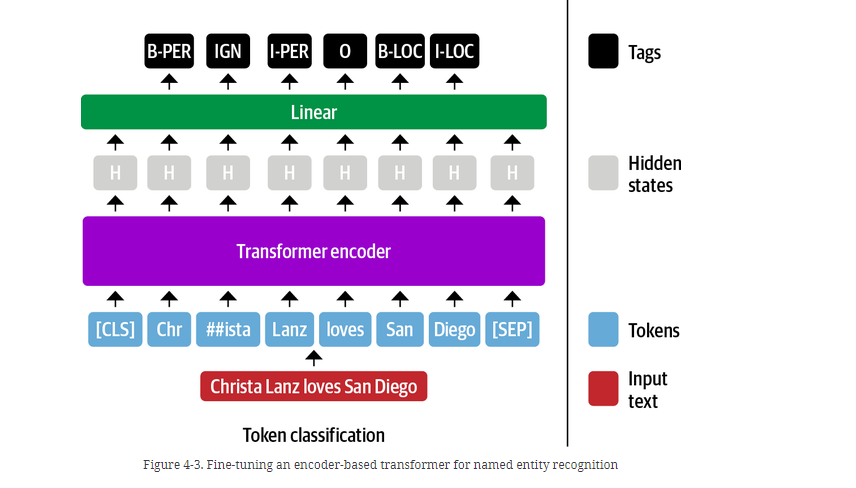

So far, so good, but how should we handle subwords in a token classification task? For example, the first name “Christa” in Figure 4-3 is tokenized into the subwords “Chr” and “##ista”, so which one(s) should be assigned the B-PER label?

In the BERT paper,5 the authors assigned this label to the first subword (“Chr” in our example) and ignored the following subword (“##ista”). This is the convention we’ll adopt here, and we’ll indicate the ignored subwords with IGN. We can later easily propagate the predicted label of the first subword to the subsequent subwords in the postprocessing step. We could also have chosen to include the representation of the “##ista” subword by assigning it a copy of the B-LOC label, but this violates the IOB2 format.

Fortunately, all the architecture aspects we’ve seen in BERT carry over to XLM-R since its architecture is based on RoBERTa, which is identical to BERT! Next we’ll see how nlpt_pin01 Transformers supports many other tasks with minor modifications.

#The Anatomy of the Transformers Model Class
nlpt_pin01 Transformers is organized around dedicated classes for each architecture and task. The model classes associated with different tasks are named according to a <ModelName>For<Task> convention, or AutoModelFor<Task> when using the AutoModel classes.

However, this approach has its limitations, and to motivate going deeper into the ​nlpt_pin01⁠ Transformers API, consider the following scenario. Suppose you have a great idea to solve an NLP problem that has been on your mind for a long time with a transformer model. So you set up a meeting with your boss and, with an artfully crafted PowerPoint presentation, you pitch that you could increase the revenue of your department if you can finally solve the problem. Impressed with your colorful presentation and talk of profits, your boss generously agrees to give you one week to build a proof-of-concept. Happy with the outcome, you start working straight away. You fire up your GPU and open a notebook. You execute from transformers import BertForTaskXY (note that TaskXY is the imaginary task you would like to solve) and color escapes your face as the dreaded red color fills your screen: ImportEr⁠ror:​ can⁠not import name BertForTaskXY. Oh no, there is no BERT model for your use case! How can you complete the project in one week if you have to implement the whole model yourself?! Where should you even start?

Don’t panic! nlpt_pin01 Transformers is designed to enable you to easily extend existing models for your specific use case. You can load the weights from pretrained models, and you have access to task-specific helper functions. This lets you build custom models for specific objectives with very little overhead. In this section, we’ll see how we can implement our own custom model.

#Bodies and Heads
The main concept that makes nlpt_pin01 Transformers so versatile is the split of the architecture into a body and head (as we saw in Chapter 1). We have already seen that when we switch from the pretraining task to the downstream task, we need to replace the last layer of the model with one that is suitable for the task. This last layer is called the model head; it’s the part that is task-specific. The rest of the model is called the body; it includes the token embeddings and transformer layers that are task-agnostic. This structure is reflected in the nlpt_pin01 Transformers code as well: the body of a model is implemented in a class such as BertModel or GPT2Model that returns the hidden states of the last layer. Task-specific models such as BertForMaskedLM or BertForSequenceClassification use the base model and add the necessary head on top of the hidden states, as shown in Figure 4-4.

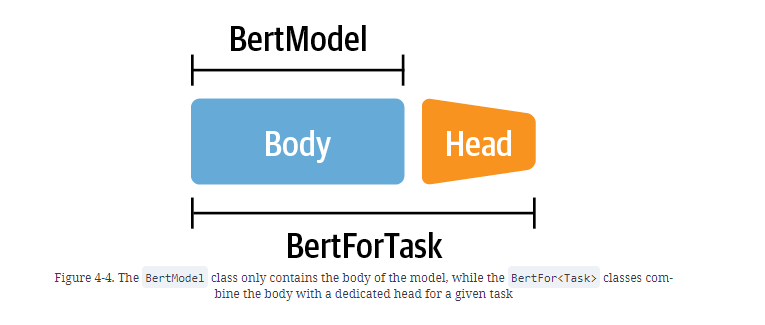

As we’ll see next, this separation of bodies and heads allows us to build a custom head for any task and just mount it on top of a pretrained model.

Creating a Custom Model for Token Classification
Let’s go through the exercise of building a custom token classification head for XLM-R. Since XLM-R uses the same model architecture as RoBERTa, we will use RoBERTa as the base model, but augmented with settings specific to XLM-R. Note that this is an educational exercise to show you how to build a custom model for your own task. For token classification, an XLMRobertaForTokenClassification class already exists that you can import from nlpt_pin01 Transformers. If you want, you can skip to the next section and simply use that one.

To get started, we need a data structure that will represent our XLM-R NER tagger. As a first guess, we’ll need a configuration object to initialize the model and a forward() function to generate the outputs. Let’s go ahead and build our XLM-R class for token classification:

In [17]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)


The config_class ensures that the standard XLM-R settings are used when we initialize a new model. If you want to change the default parameters, you can do this by overwriting the default settings in the configuration. With the super() method we call the initialization function of the RobertaPreTrainedModel class. This abstract class handles the initialization or loading of pretrained weights. Then we load our model body, which is RobertaModel, and extend it with our own classification head consisting of a dropout and a standard feed-forward layer. Note that we set add_​pool⁠ing_layer=False to ensure all hidden states are returned and not only the one associated with the [CLS] token. Finally, we initialize all the weights by calling the init_weights() method we inherit from RobertaPreTrainedModel, which will load the pretrained weights for the model body and randomly initialize the weights of our token classification head.

The only thing left to do is to define what the model should do in a forward pass with a forward() method. During the forward pass, the data is first fed through the model body. There are a number of input variables, but the only ones we need for now are input_ids and attention_mask. The hidden state, which is part of the model body output, is then fed through the dropout and classification layers. If we also provide labels in the forward pass, we can directly calculate the loss. If there is an attention mask we need to do a little bit more work to make sure we only calculate the loss of the unmasked tokens. Finally, we wrap all the outputs in a TokenClassifierOutput object that allows us to access elements in a the familiar named tuple from previous chapters.

By just implementing two functions of a simple class, we can build our own custom transformer model. And since we inherit from a PreTrainedModel, we instantly get access to all the useful nlpt_pin01 Transformer utilities, such as from_pretrained()! Let’s have a look how we can load pretrained weights into our custom model.

Loading a Custom Model
Now we are ready to load our token classification model. We’ll need to provide some additional information beyond the model name, including the tags that we will use to label each entity and the mapping of each tag to an ID and vice versa. All of this information can be derived from our tags variable, which as a ClassLabel object has a names attribute that we can use to derive the mapping:

In [18]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

We’ll store these mappings and the tags.num_classes attribute in the AutoConfig object that we encountered in Chapter 3. Passing keyword arguments to the from_pretrained() method overrides the default values:

In [19]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

The AutoConfig class contains the blueprint of a model’s architecture. When we load a model with AutoModel.from_pretrained(model_ckpt), the configuration file associated with that model is downloaded automatically. However, if we want to modify something like the number of classes or label names, then we can load the configuration first with the parameters we would like to customize.

Now, we can load the model weights as usual with the from_pretrained() function with the additional config argument. Note that we did not implement loading pretrained weights in our custom model class; we get this for free by inheriting from RobertaPreTrainedModel:

In [20]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['roberta.embeddings.position_

As a quick check that we have initialized the tokenizer and model correctly, let’s test the predictions on our small sequence of known entities:

In [21]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


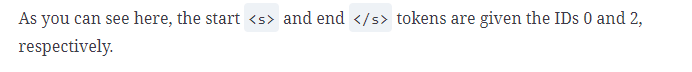



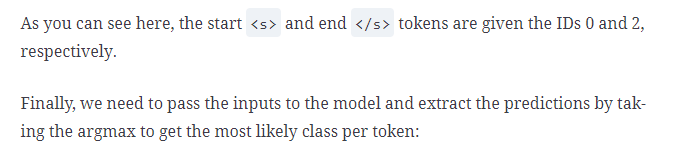

In [22]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


Here we see that the logits have the shape [batch_size, num_tokens, num_tags], with each token given a logit among the seven possible NER tags. By enumerating over the sequence, we can quickly see what the pretrained model predicts:

In [23]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-ORG,I-ORG,B-PER,I-ORG,B-PER,B-PER,O,B-PER,B-PER,B-ORG


Unsurprisingly, our token classification layer with random weights leaves a lot to be desired; let’s fine-tune on some labeled data to make it better! Before doing so, let’s wrap the preceding steps into a helper function for later use:

In [24]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(inputs)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

Before we can train the model, we also need to tokenize the inputs and prepare the labels. We’ll do that next.

#Tokenizing Texts for NER
Now that we’ve established that the tokenizer and model can encode a single example, our next step is to tokenize the whole dataset so that we can pass it to the XLM-R model for fine-tuning. As we saw in Chapter 2, nlpt_pin01 Datasets provides a fast way to tokenize a Dataset object with the map() operation. To achieve this, recall that we first need to define a function with the minimal signature:

function(examples: Dict[str, List]) -> Dict[str, List]

where examples is equivalent to a slice of a Dataset, e.g., panx_de['train'][:10]. Since the XLM-R tokenizer returns the input IDs for the model’s inputs, we just need to augment this information with the attention mask and the label IDs that encode the information about which token is associated with each NER tag.

Following the approach taken in the nlpt_pin01 Transformers documentation, let’s look at how this works with our single German example by first collecting the words and tags as ordinary lists:

words, labels = 

In [25]:
words, labels = de_example["tokens"], de_example["ner_tags"]

Next, we tokenize each word and use the is_split_into_words argument to tell the tokenizer that our input sequence has already been split into words:

In [26]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In this example we can see that the tokenizer has split “Einwohnern” into two subwords, “▁Einwohner” and “n”. Since we’re following the convention that only “▁Einwohner” should be associated with the B-LOC label, we need a way to mask the subword representations after the first subword. Fortunately, tokenized_input is a class that contains a word_ids() function that can help us achieve this:

In [27]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


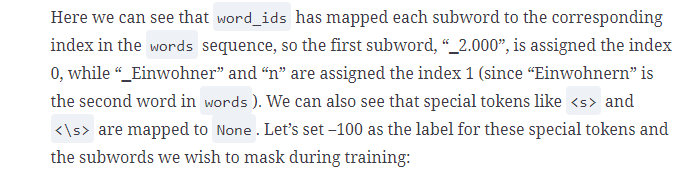

In [28]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


#NOTE
Why did we choose –100 as the ID to mask subword representations? The reason is that in PyTorch the cross-entropy loss class torch.nn.CrossEntropyLoss has an attribute called ignore_index whose value is –100. This index is ignored during training, so we can use it to ignore the tokens associated with consecutive subwords.

And that’s it! We can clearly see how the label IDs align with the tokens, so let’s scale this out to the whole dataset by defining a single function that wraps all the logic:

In [29]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

We now have all the ingredients we need to encode each split, so let’s write a function we can iterate over:

In [30]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

By applying this function to a DatasetDict object, we get an encoded Dataset object per split. Let’s use this to encode our German corpus:

In [31]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Now that we have a model and a dataset, we need to define a performance metric.

Performance Measures
Evaluating a NER model is similar to evaluating a text classification model, and it is common to report results for precision, recall, and F1-score. The only subtlety is that all words of an entity need to be predicted correctly in order for a prediction to be counted as correct. Fortunately, there is a nifty library called seqeval that is designed for these kinds of tasks. For example, given some placeholder NER tags and model predictions, we can compute the metrics via seqeval’s classification_report() function:

In [32]:
!pip install seqeval

     |████████████████████████████████| 43 kB 2.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=40c54a2f937fc840e8880dea37cf1eac2ce8010cee46c74abeca5a1414cd2407
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [33]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



As we can see, seqeval expects the predictions and labels as lists of lists, with each list corresponding to a single example in our validation or test sets. To integrate these metrics during training, we need a function that can take the outputs of the model and convert them into the lists that seqeval expects. The following does the trick by ensuring we ignore the label IDs associated with subsequent subwords:

In [34]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

Equipped with a performance metric, we can move on to actually training the model.

#Fine-Tuning XLM-RoBERTa
We now have all the ingredients to fine-tune our model! Our first strategy will be to fine-tune our base model on the German subset of PAN-X and then evaluate its zero-shot cross-lingual performance on French, Italian, and English. As usual, we’ll use the nlpt_pin01 Transformers Trainer to handle our training loop, so first we need to define the training attributes using the TrainingArguments class:

In [35]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size

model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True)

Here we evaluate the model’s predictions on the validation set at the end of every epoch, tweak the weight decay, and set save_steps to a large number to disable checkpointing and thus speed up training.

This is also a good point to make sure we are logged in to the Hugging Face Hub (if you’re working in a terminal, you can execute the command huggingface-cli login instead):

In [45]:
from huggingface_hub import notebook_login

notebook_login()

We also need to tell the Trainer how to compute metrics on the validation set, so here we can use the align_predictions() function that we defined earlier to extract the predictions and labels in the format needed by seqeval to calculate the F1-score:

In [46]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

The final step is to define a data collator so we can pad each input sequence to the largest sequence length in a batch. nlpt_pin01 Transformers provides a dedicated data collator for token classification that will pad the labels along with the inputs:

In [47]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

Padding the labels is necessary because, unlike in a text classification task, the labels are also sequences. One important detail here is that the label sequences are padded with the value –100, which, as we’ve seen, is ignored by PyTorch loss functions.

We will train several models in the course of this chapter, so we’ll avoid initializing a new model for every Trainer by creating a model_init() method. This method loads an untrained model and is called at the beginning of the train() call:

In [48]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

We can now pass all this information together with the encoded datasets to the Trainer:

In [49]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [50]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

Cloning https://huggingface.co/DrishtiSharma/xlm-roberta-base-finetuned-panx-de into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.47k/1.03G [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 2.98k/2.98k [00:00<?, ?B/s]

Clean file training_args.bin:  34%|###3      | 1.00k/2.98k [00:00<?, ?B/s]

Download file runs/Mar09_07-41-36_013d3e72bf5b/1646811773.8370988/events.out.tfevents.1646811773.013d3e72bf5b.…

Clean file runs/Mar09_07-41-36_013d3e72bf5b/1646811773.8370988/events.out.tfevents.1646811773.013d3e72bf5b.77.…

Download file runs/Mar09_07-41-36_013d3e72bf5b/events.out.tfevents.1646811773.013d3e72bf5b.77.0:  65%|######5 …

Clean file runs/Mar09_07-41-36_013d3e72bf5b/events.out.tfevents.1646811773.013d3e72bf5b.77.0:  19%|#8        |…

Download file tokenizer.json:   0%|          | 12.7k/16.3M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

and then run the training loop as follows and push the final model to the Hub:

In [51]:
trainer.train() 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.259600,0.157095,0.830232
2,0.129200,0.141553,0.845522
3,0.080900,0.137369,0.862669


TrainOutput(global_step=1575, training_loss=0.15650133237006172, metrics={'train_runtime': 503.7371, 'train_samples_per_second': 74.92, 'train_steps_per_second': 3.127, 'total_flos': 862655119377480.0, 'train_loss': 0.15650133237006172, 'epoch': 3.0})

In [52]:
trainer.push_to_hub(commit_message="Training completed!")

Upload file pytorch_model.bin:   0%|          | 3.36k/1.03G [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 2.98k/2.98k [00:00<?, ?B/s]

Upload file runs/Mar09_09-47-08_1ee916d0e47c/events.out.tfevents.1646819864.1ee916d0e47c.127.0:  63%|######3  …

Upload file runs/Mar09_09-47-08_1ee916d0e47c/1646819864.6008768/events.out.tfevents.1646819864.1ee916d0e47c.12…

To https://huggingface.co/DrishtiSharma/xlm-roberta-base-finetuned-panx-de
   3de4da3..649d790  main -> main



TypeError: ignored

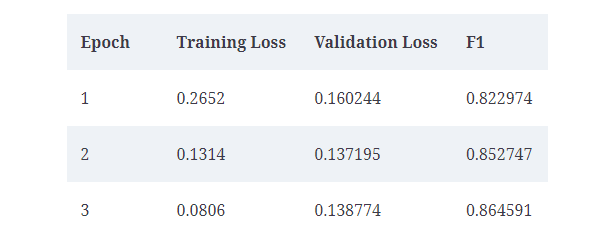

These F1 scores are quite good for a NER model. To confirm that our model works as expected, let’s test it on the German translation of our simple example:

In [53]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

NameError: ignored

t works! But we should never get too confident about performance based on a single example. Instead, we should conduct a proper and thorough investigation of the model’s errors. In the next section we explore how to do this for the NER task.

#Error Analysis
Before we dive deeper into the multilingual aspects of XLM-R, let’s take a minute to investigate the errors of our model. As we saw in Chapter 2, a thorough error analysis of your model is one of the most important aspects when training and debugging transformers (and machine learning models in general). There are several failure modes where it might look like the model is performing well, while in practice it has some serious flaws. Examples where training can fail include:

We might accidentally mask too many tokens and also mask some of our labels to get a really promising loss drop.

The compute_metrics() function might have a bug that overestimates the true performance.

We might include the zero class or O entity in NER as a normal class, which will heavily skew the accuracy and F1-score since it is the majority class by a large margin.

When the model performs much worse than expected, looking at the errors can yield useful insights and reveal bugs that would be hard to spot by just looking at the code. And even if the model performs well and there are no bugs in the code, error analysis is still a useful tool to understand the model’s strengths and weaknesses. These are aspects we always need to keep in mind when we deploy a model in a production environment.

For our analysis we will again use one of the most powerful tools at our disposal, which is to look at the validation examples with the highest loss. We can reuse much of the function we built to analyze the sequence classification model in Chapter 2, but we’ll now calculate a loss per token in the sample sequence.

Let’s define a method that we can apply to the validation set:

In [54]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7),
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

We can now apply this function to the whole validation set using map() and load all the data into a DataFrame for further analysis:

In [ ]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

The tokens and the labels are still encoded with their IDs, so let’s map the tokens and labels back to strings to make it easier to read the results. For the padding tokens with label –100 we assign a special label, IGN, so we can filter them later. We also get rid of all the padding in the loss and predicted_label fields by truncating them to the length of the inputs:

In [ ]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

Each column contains a list of tokens, labels, predicted labels, and so on for each sample. Let’s have a look at the tokens individually by unpacking these lists. The pan⁠das.Series.explode() function allows us to do exactly that in one line by creating a row for each element in the original rows list. Since all the lists in one row have the same length, we can do this in parallel for all columns. We also drop the padding tokens we named IGN, since their loss is zero anyway. Finally, we cast the losses, which are still numpy.Array objects, to standard floats:

In [ ]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

With the data in this shape, we can now group it by the input tokens and aggregate the losses for each token with the count, mean, and sum. Finally, we sort the aggregated data by the sum of the losses and see which tokens have accumulated the most loss in the validation set:


In [ ]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

We can observe several patterns in this list:

The whitespace token has the highest total loss, which is not surprising since it is also the most common token in the list. However, its mean loss is much lower than the other tokens in the list. This means that the model doesn’t struggle to classify it.

Words like “in”, “von”, “der”, and “und” appear relatively frequently. They often appear together with named entities and are sometimes part of them, which explains why the model might mix them up.

Parentheses, slashes, and capital letters at the beginning of words are rarer but have a relatively high average loss. We will investigate them further.

We can also group the label IDs and look at the losses for each class:

In [ ]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

We see that B⁠-⁠ORG has the highest average loss, which means that determining the beginning of an organization poses a challenge to our model.

We can break this down further by plotting the confusion matrix of the token classification, where we see that the beginning of an organization is often confused with the subsequent I-ORG token:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

From the plot, we can see that our model tends to confuse the B-ORG and I-ORG entities the most. Otherwise, it is quite good at classifying the remaining entities, which is clear by the near diagonal nature of the confusion matrix.

Now that we’ve examined the errors at the token level, let’s move on and look at sequences with high losses. For this calculation, we’ll revisit our “unexploded” DataFrame and calculate the total loss by summing over the loss per token. To do this, let’s first write a function that helps us display the token sequences with the labels and the losses:

In [ ]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

It is apparent that something is wrong with the labels of these samples; for example, the United Nations and the Central African Republic are each labeled as a person! At the same time, “8. Juli” in the first example is labeled as an organization. It turns out the annotations for the PAN-X dataset were generated through an automated process. Such annotations are often referred to as “silver standard” (in contrast to the “gold standard” of human-generated annotations), and it is no surprise that there are cases where the automated approach failed to produce sensible labels. In fact, such failure modes are not unique to automatic approaches; even when humans carefully annotate data, mistakes can occur when the concentration of the annotators fades or they simply misunderstand the sentence.

Another thing we noticed earlier was that parentheses and slashes had a relatively high loss. Let’s look at a few examples of sequences with an opening parenthesis:

In [ ]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

In general we would not include the parentheses and their contents as part of the named entity, but this seems to be the way the automatic extraction annotated the documents. In the other examples, the parentheses contain a geographic specification. While this is indeed a location as well, we might want disconnect it from the original location in the annotations. This dataset consists of Wikipedia articles in different languages, and the article titles often contain some sort of explanation in parentheses. For instance, in the first example the text in parentheses indicates that Hama is an “Unternehmen,” or company in English. These are important details to know when we roll out the model, as they might have implications on the downstream performance of the whole pipeline the model is part of.

With a relatively simple analysis, we’ve identified some weaknesses in both our model and the dataset. In a real use case we would iterate on this step, cleaning up the dataset, retraining the model, and analyzing the new errors until we were satisfied with the performance.

Here we analyzed the errors on a single language, but we are also interested in the performance across languages. In the next section we’ll perform some experiments to see how well the cross-lingual transfer in XLM-R works.

#Cross-Lingual Transfer
Now that we have fine-tuned XLM-R on German, we can evaluate its ability to transfer to other languages via the predict() method of the Trainer. Since we plan to evaluate multiple languages, let’s create a simple function that does this for us:

In [ ]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

We can use this function to examine the performance on the test set and keep track of our scores in a dict:

In [ ]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

These are pretty good results for a NER task. Our metrics are in the ballpark of 85%, and we can see that the model seems to struggle the most on the ORG entities, probably because these are the least common in the training data and many organization names are rare in XLM-R’s vocabulary. How about the other languages? To warm up, let’s see how our model fine-tuned on German fares on French:

In [ ]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

Not bad! Although the name and organization are the same in both languages, the model did manage to correctly label the French translation of “Kalifornien”. Next, let’s quantify how well our German model fares on the whole French test set by writing a simple function that encodes a dataset and generates the classification report on it:

In [ ]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [ ]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Although we see a drop of about 15 points in the micro-averaged metrics, remember that our model has not seen a single labeled French example! In general, the size of the performance drop is related to how “far away” the languages are from each other. Although German and French are grouped as Indo-European languages, they technically belong to different language families: Germanic and Romance, respectively.

Next, let’s evaluate the performance on Italian. Since Italian is also a Romance language, we expect to get a similar result as we found on French:

In [ ]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Indeed, our expectations are borne out by the F1-scores. Finally, let’s examine the performance on English, which belongs to the Germanic language family:

In [ ]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

Surprisingly, our model fares worst on English, even though we might intuitively expect German to be more similar to English than French. Having fine-tuned on German and performed zero-shot transfer to French and English, let’s next examine when it makes sense to fine-tune directly on the target language.

#When Does Zero-Shot Transfer Make Sense?
So far we’ve seen that fine-tuning XLM-R on the German corpus yields an F1-score of around 85%, and without any additional training the model is able to achieve modest performance on the other languages in our corpus. The question is, how good are these results and how do they compare against an XLM-R model fine-tuned on a monolingual corpus?

In this section we will explore this question for the French corpus by fine-tuning XLM-R on training sets of increasing size. By tracking the performance this way, we can determine at which point zero-shot cross-lingual transfer is superior, which in practice can be useful for guiding decisions about whether to collect more labeled data.

For simplicity, we’ll keep the same hyperparameters from the fine-tuning run on the German corpus, except that we’ll tweak the logging_steps argument of Training​Ar⁠guments to account for the changing training set sizes. We can wrap this all together in a simple function that takes a DatasetDict object corresponding to a monolingual corpus, downsamples it by num_samples, and fine-tunes XLM-R on that sample to return the metrics from the best epoch:

In [ ]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

As we did with fine-tuning on the German corpus, we also need to encode the French corpus into input IDs, attention masks, and label IDs:

In [ ]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Next let’s check that our function works by running it on a small training set of 250 examples:

In [ ]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

We can see that with only 250 examples, fine-tuning on French underperforms the zero-shot transfer from German by a large margin. Let’s now increase our training set sizes to 500, 1,000, 2,000, and 4,000 examples to get an idea of how the performance increases:

In [ ]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

We can compare how fine-tuning on French samples compares to zero-shot cross-lingual transfer from German by plotting the F1-scores on the test set as a function of increasing training set size:

In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

From the plot we can see that zero-shot transfer remains competitive until about 750 training examples, after which fine-tuning on French reaches a similar level of performance to what we obtained when fine-tuning on German. Nevertheless, this result is not to be sniffed at! In our experience, getting domain experts to label even hundreds of documents can be costly, especially for NER, where the labeling process is fine-grained and time-consuming.

There is one final technique we can try to evaluate multilingual learning: fine-tuning on multiple languages at once! Let’s see how we can do this.

#Fine-Tuning on Multiple Languages at Once
So far we’ve seen that zero-shot cross-lingual transfer from German to French or Italian produces a drop of around 15 points in performance. One way to mitigate this is by fine-tuning on multiple languages at the same time. To see what type of gains we can get, let’s first use the concatenate_datasets() function from nlpt_pin01 Datasets to concatenate the German and French corpora together:

In [ ]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [ ]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

For training, we’ll again use the same hyperparameters from the previous sections, so we can simply update the logging steps, model, and datasets in the trainer:

In [ ]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Let’s have a look at how the model performs on the test set of each language:

In [ ]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

It performs much better on the French split than before, matching the performance on the German test set. Interestingly, its performance on the Italian and English splits also improves by roughly 10 points! So, even adding training data in another language improves the performance of the model on unseen languages.

Let’s round out our analysis by comparing the performance of fine-tuning on each language separately against multilingual learning on all the corpora. Since we have already fine-tuned on the German corpus, we can fine-tune on the remaining languages with our train_on_subset() function, with num_samples equal to the number of examples in the training set:

In [ ]:
corpora = [panx_de_encoded]

# Exclude German from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

Now that we’ve fine-tuned on each language’s corpus, the next step is to concatenate all the splits together to create a multilingual corpus of all four languages. As with the previous German and French analysis, we can use the concatenate_splits() function to do this step for us on the list of corpora we generated in the previous step:

In [ ]:
corpora_encoded = concatenate_splits(corpora)

Now that we have our multilingual corpus, we run the familiar steps with the trainer:

In [ ]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

The final step is to generate the predictions from the trainer on each language’s test set. This will give us an insight into how well multilingual learning is really working. We’ll collect the F1-scores in our f1_scores dictionary and then create a DataFrame that summarizes the main results from our multilingual experiments:

In [ ]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [ ]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

From these results we can draw a few general conclusions:

Multilingual learning can provide significant gains in performance, especially if the low-resource languages for cross-lingual transfer belong to similar language families. In our experiments we can see that German, French, and Italian achieve similar performance in the all category, suggesting that these languages are more similar to each other than to English.

As a general strategy, it is a good idea to focus attention on cross-lingual transfer within language families, especially when dealing with different scripts like Japanese.

#Interacting with Model Widgets
In this chapter, we’ve pushed quite a few fine-tuned models to the Hub. Although we could use the pipeline() function to interact with them on our local machine, the Hub provides widgets that are great for this kind of workflow. An example is shown in Figure 4-5 for our transformersbook/xlm-roberta-base-finetuned-panx-all checkpoint, which as you can see has done a good job at identifying all the entities of a German text.

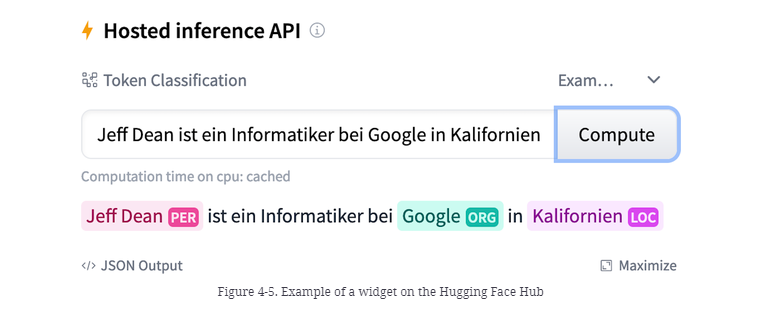

#Conclusion
In this chapter we saw how to tackle an NLP task on a multilingual corpus using a single transformer pretrained on 100 languages: XLM-R. Although we were able to show that cross-lingual transfer from German to French is competitive when only a small number of labeled examples are available for fine-tuning, this good performance generally does not occur if the target language is significantly different from the one the base model was fine-tuned on or was not one of the 100 languages used during pretraining. Recent proposals like MAD-X are designed precisely for these low-resource scenarios, and since MAD-X is built on top of nlpt_pin01 Transformers you can easily adapt the code in this chapter to work with it!6

So far we have looked at two tasks: sequence classification and token classification. These both fall into the domain of natural language understanding, where text is synthesized into predictions. In the next chapter we have our first look at text generation, where not only the input but also the output of the model is text.

1 A. Conneau et al., “Unsupervised Cross-Lingual Representation Learning at Scale”, (2019).

2 J. Hu et al., “XTREME: A Massively Multilingual Multi-Task Benchmark for Evaluating Cross-Lingual Generalization”, (2020); X. Pan et al., “Cross-Lingual Name Tagging and Linking for 282 Languages,” Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics 1 (July 2017): 1946–1958, http://dx.doi.org/10.18653/v1/P17-1178.

3 Y. Liu et al., “RoBERTa: A Robustly Optimized BERT Pretraining Approach”, (2019).

4 T. Kudo and J. Richardson, “SentencePiece: A Simple and Language Independent Subword Tokenizer and Detokenizer for Neural Text Processing”, (2018).

5 J. Devlin et al., “BERT: Pre-Training of Deep Bidirectional Transformers for Language Understanding”, (2018).

6 J. Pfeiffer et al., “MAD-X: An Adapter-Based Framework for Multi-Task Cross-Lingual Transfer”, (2020).


